In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ariel-data-challenge-2025/axis_info.parquet
/kaggle/input/ariel-data-challenge-2025/sample_submission.csv
/kaggle/input/ariel-data-challenge-2025/test_star_info.csv
/kaggle/input/ariel-data-challenge-2025/train.csv
/kaggle/input/ariel-data-challenge-2025/wavelengths.csv
/kaggle/input/ariel-data-challenge-2025/train_star_info.csv
/kaggle/input/ariel-data-challenge-2025/adc_info.csv
/kaggle/input/ariel-data-challenge-2025/test/1103775/AIRS-CH0_signal_1.parquet
/kaggle/input/ariel-data-challenge-2025/test/1103775/FGS1_signal_0.parquet
/kaggle/input/ariel-data-challenge-2025/test/1103775/FGS1_signal_1.parquet
/kaggle/input/ariel-data-challenge-2025/test/1103775/AIRS-CH0_signal_0.parquet
/kaggle/input/ariel-data-challenge-2025/test/1103775/AIRS-CH0_calibration_0/dead.parquet
/kaggle/input/ariel-data-challenge-2025/test/1103775/AIRS-CH0_calibration_0/linear_corr.parquet
/kaggle/input/ariel-data-challenge-2025/test/1103775/AIRS-CH0_calibration_0/read.parquet
/kaggle/input/ariel-

# Setup & Environment

In [2]:
# CELL 1: Install dependencies (if not already installed)
!pip install kaggle pyarrow lightgbm xgboost

In [3]:
# Import library utama untuk kompetisi Ariel Data Challenge 2025

import os
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import torch

2025-07-19 06:33:56.931790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752906837.122849      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752906837.181148      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load & Verifikasi Data

In [5]:
# Load & Verifikasi Data (Kaggle Path) — Robust ADC Extraction

import os
import pandas as pd
import pyarrow.parquet as pq

# 1. Paths
DATA_DIR  = "/kaggle/input/ariel-data-challenge-2025"
TRAIN_DIR = os.path.join(DATA_DIR, "train")

# 2. Load metadata
train_df           = pd.read_csv (os.path.join(DATA_DIR, "train.csv"))
wavelengths_df     = pd.read_csv (os.path.join(DATA_DIR, "wavelengths.csv"))
axis_info_df       = pd.read_parquet(os.path.join(DATA_DIR, "axis_info.parquet"))
adc_df             = pd.read_csv (os.path.join(DATA_DIR, "adc_info.csv"))
star_info_train_df = pd.read_csv (os.path.join(DATA_DIR, "train_star_info.csv"))

print("Loaded metadata shapes:")
print(f" - train.csv:           {train_df.shape}")
print(f" - wavelengths.csv:     {wavelengths_df.shape}")
print(f" - axis_info.parquet:   {axis_info_df.shape}")
print(f" - adc_info.csv:        {adc_df.shape}")
print(f" - train_star_info.csv: {star_info_train_df.shape}\n")

# 3. Inspect adc_info to understand its format
print("ADC info preview:")
print(adc_df.head(), "\n")
print("ADC info columns:", adc_df.columns.tolist(), "\n")

# 4. Robust extraction of gain/offset values
gain_airs = offset_airs = gain_fgs1 = offset_fgs1 = None

for col in adc_df.columns:
    low = col.lower()
    if 'gain' in low and 'airs' in low:
        gain_airs = float(adc_df[col].iloc[0])
    if 'offset' in low and 'airs' in low:
        offset_airs = float(adc_df[col].iloc[0])
    if 'gain' in low and 'fgs' in low:
        gain_fgs1 = float(adc_df[col].iloc[0])
    if 'offset' in low and 'fgs' in low:
        offset_fgs1 = float(adc_df[col].iloc[0])

assert None not in (gain_airs, offset_airs, gain_fgs1, offset_fgs1), "Failed to find ADC parameters!"

print(f"AIRS-CH0 → gain={gain_airs}, offset={offset_airs}")
print(f"FGS1    → gain={gain_fgs1}, offset={offset_fgs1}\n")

# 5. List planet IDs
planet_ids = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
print(f"Found {len(planet_ids)} planets, example: {planet_ids[:5]}\n")

# 6. Example: read & calibrate AIRS-CH0 signal for first planet
planet = planet_ids[0]
signal_path = os.path.join(TRAIN_DIR, planet, "AIRS-CH0_signal_0.parquet")
df_signal = pd.read_parquet(signal_path)

# reshape and calibrate
signal = df_signal.values.reshape(11250, 32, 356).astype('float64')
signal_calibrated = signal / gain_airs + offset_airs

print("AIRS-CH0 calibrated shape:", signal_calibrated.shape)
print("Value range:", signal_calibrated.min(), "to", signal_calibrated.max())

Loaded metadata shapes:
 - train.csv:           (1100, 284)
 - wavelengths.csv:     (1, 283)
 - axis_info.parquet:   (135000, 4)
 - adc_info.csv:        (1, 4)
 - train_star_info.csv: (1100, 9)

ADC info preview:
   FGS1_adc_offset  FGS1_adc_gain  AIRS-CH0_adc_offset  AIRS-CH0_adc_gain
0          -1000.0         0.4369              -1000.0             0.4369 

ADC info columns: ['FGS1_adc_offset', 'FGS1_adc_gain', 'AIRS-CH0_adc_offset', 'AIRS-CH0_adc_gain'] 

AIRS-CH0 → gain=0.4369, offset=-1000.0
FGS1    → gain=0.4369, offset=-1000.0

Found 1100 planets, example: ['1253730513', '1143471509', '3597945304', '3255645778', '4020731390']

AIRS-CH0 calibrated shape: (11250, 32, 356)
Value range: -679.5605401693751 to 81348.36346990158


# Exploratory Data Analysis (EDA)

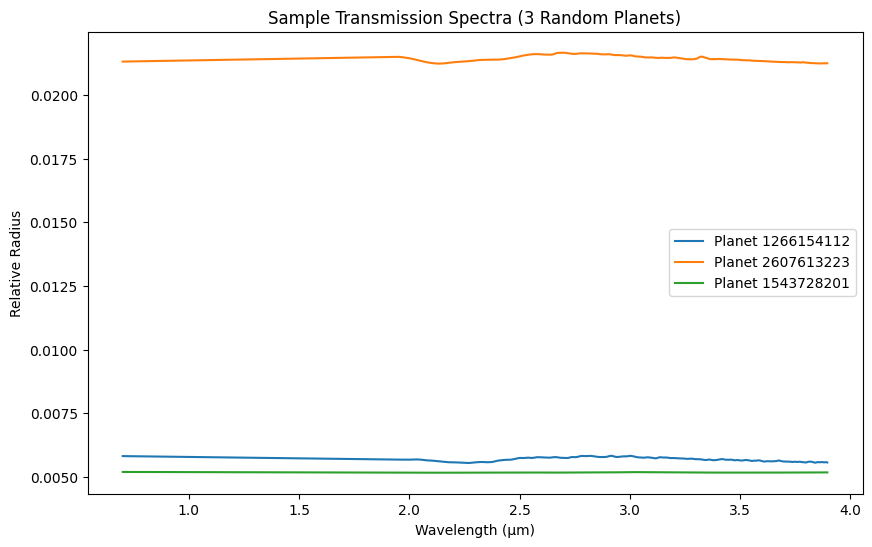

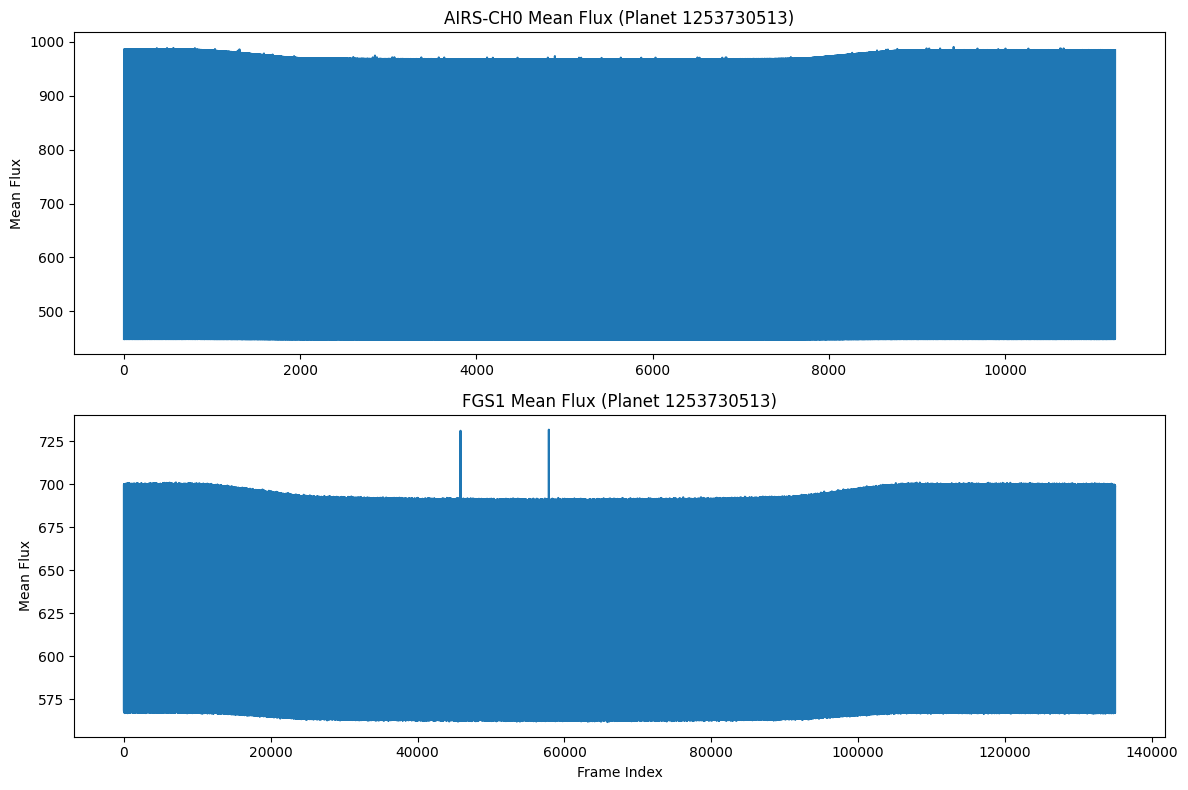

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


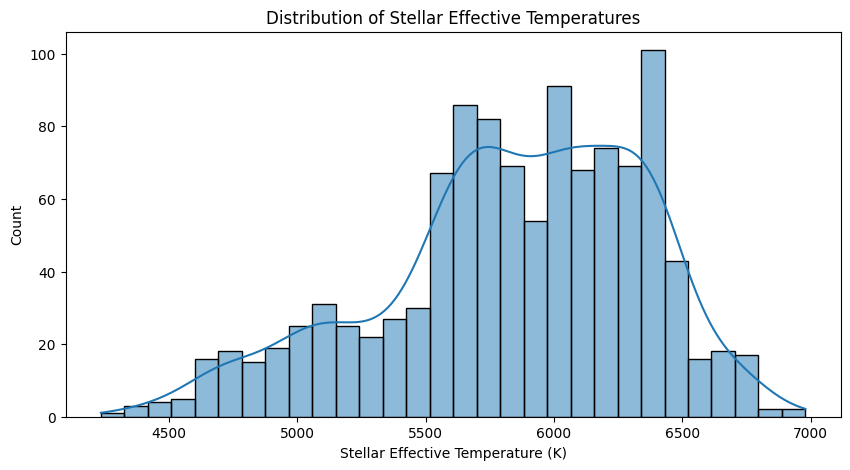

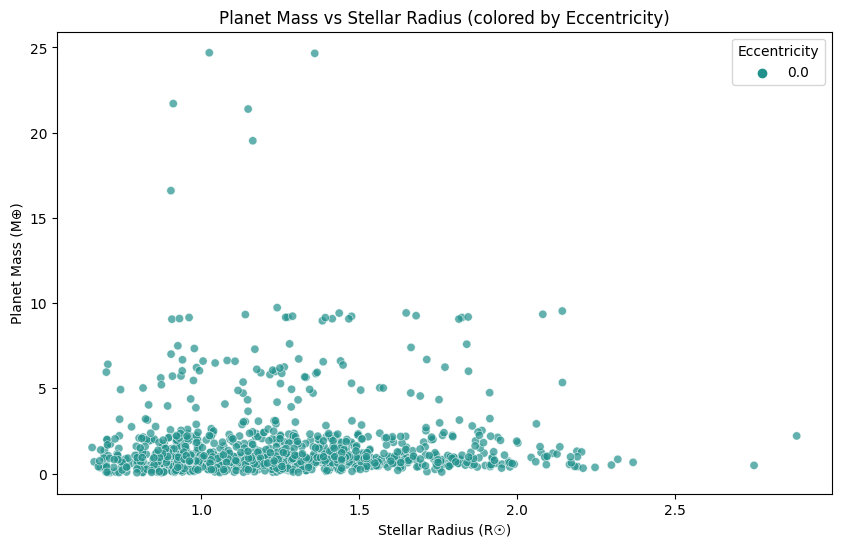

In [6]:
# ================================
# Exploratory Data Analysis (EDA)
# ================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Paths
DATA_DIR  = "/kaggle/input/ariel-data-challenge-2025"  # adjust as needed
TRAIN_DIR = os.path.join(DATA_DIR, "train")

# 1. Load metadata
train_df       = pd.read_csv (os.path.join(DATA_DIR, "train.csv"))
wavelengths_df = pd.read_csv (os.path.join(DATA_DIR, "wavelengths.csv"))
star_info_df   = pd.read_csv (os.path.join(DATA_DIR, "train_star_info.csv"))

# 2. List of planet IDs
planet_ids = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]

# 3. Sample Transmission Spectra
wavelengths = wavelengths_df.values.flatten()
sample_ids  = train_df['planet_id'].sample(3, random_state=42).values

plt.figure(figsize=(10, 6))
for pid in sample_ids:
    spec = train_df.loc[train_df['planet_id']==pid].iloc[0, 1:].astype(float).values
    plt.plot(wavelengths, spec, label=f"Planet {pid}")
plt.xlabel("Wavelength (µm)")
plt.ylabel("Relative Radius")
plt.title("Sample Transmission Spectra (3 Random Planets)")
plt.legend()
plt.show()

# 4. Time-series Mean Flux for One Planet (AIRS-CH0 & FGS1)
pid = planet_ids[0]

# AIRS-CH0
df_airs = pd.read_parquet(os.path.join(TRAIN_DIR, pid, "AIRS-CH0_signal_0.parquet"))
sig_airs = df_airs.values.reshape(11250, 32, 356).astype(float)
flux_airs = sig_airs.mean(axis=(1,2))

# FGS1
df_fgs1  = pd.read_parquet(os.path.join(TRAIN_DIR, pid, "FGS1_signal_0.parquet"))
sig_fgs1 = df_fgs1.values.reshape(135000, 32, 32).astype(float)
flux_fgs1= sig_fgs1.mean(axis=(1,2))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(flux_airs)
ax1.set_title(f"AIRS-CH0 Mean Flux (Planet {pid})")
ax1.set_ylabel("Mean Flux")

ax2.plot(flux_fgs1)
ax2.set_title(f"FGS1 Mean Flux (Planet {pid})")
ax2.set_ylabel("Mean Flux")
ax2.set_xlabel("Frame Index")
plt.tight_layout()
plt.show()

# 5. Stellar Parameter Distributions
plt.figure(figsize=(10, 5))
sns.histplot(star_info_df['Ts'], bins=30, kde=True)
plt.xlabel("Stellar Effective Temperature (K)")
plt.title("Distribution of Stellar Effective Temperatures")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=star_info_df,
    x='Rs', y='Mp',
    hue='e', palette='viridis', alpha=0.7
)
plt.xlabel("Stellar Radius (R☉)")
plt.ylabel("Planet Mass (M⊕)")
plt.title("Planet Mass vs Stellar Radius (colored by Eccentricity)")
plt.legend(title="Eccentricity")
plt.show()

# Preprocessing & Feature Engineering

In [8]:
# ================================
# 4. Preprocessing & Feature Engineering (Revised ADC Extraction)
# ================================

import os
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter

# 0. Adjust this to your dataset root
ROOT_DATA = "/kaggle/input/ariel-data-challenge-2025"
TRAIN_DIR = os.path.join(ROOT_DATA, "train")

# 1. Load ADC calibration parameters robustly
adc_df = pd.read_csv(os.path.join(ROOT_DATA, "adc_info.csv"))

gain_airs = offset_airs = gain_fgs1 = offset_fgs1 = None
for col in adc_df.columns:
    lc = col.lower()
    if "airs" in lc and "gain" in lc:
        gain_airs = float(adc_df[col].iloc[0])
    if "airs" in lc and "offset" in lc:
        offset_airs = float(adc_df[col].iloc[0])
    if "fgs" in lc and "gain" in lc:
        gain_fgs1 = float(adc_df[col].iloc[0])
    if "fgs" in lc and "offset" in lc:
        offset_fgs1 = float(adc_df[col].iloc[0])

assert None not in (gain_airs, offset_airs, gain_fgs1, offset_fgs1), "ADC parameters missing!"

print(f"AIRS-CH0 → gain={gain_airs}, offset={offset_airs}")
print(f"FGS1    → gain={gain_fgs1}, offset={offset_fgs1}")

# 2. Helper functions
def load_and_calibrate(path_signal, gain, offset, path_dark=None, path_flat=None):
    df = pd.read_parquet(path_signal)
    n_frames, _ = df.shape
    H, W = (32, 356) if "AIRS-CH0" in path_signal else (32, 32)
    arr = df.values.reshape(n_frames, H, W).astype(float)
    if path_dark and os.path.exists(path_dark):
        d = pd.read_parquet(path_dark)
        if d.shape[1] == H*W:
            md = d.values.mean(axis=0).reshape(H, W)
            arr -= md[None, ...]
    if path_flat and os.path.exists(path_flat):
        f = pd.read_parquet(path_flat)
        if f.shape[1] == H*W:
            mf = f.values.mean(axis=0).reshape(H, W)
            arr /= mf[None, ...]
    return arr / gain + offset

def detrend_lightcurve(arr, window_length=101, polyorder=3):
    lc = arr.mean(axis=(1,2))
    trend = savgol_filter(lc, window_length, polyorder)
    return lc - trend + trend.mean()

def extract_ts_features(lc):
    s = pd.Series(lc)
    return {
        "ts_mean":   lc.mean(),
        "ts_std":    lc.std(),
        "ts_skew":   s.skew(),
        "ts_kurt":   s.kurtosis(),
        "ts_min":    lc.min(),
        "ts_max":    lc.max(),
        "ts_median": np.median(lc),
        "ts_iqr":    np.percentile(lc,75) - np.percentile(lc,25),
    }

# 3. Example use: one planet, AIRS-CH0
planet = os.listdir(TRAIN_DIR)[0]
sig_path  = os.path.join(TRAIN_DIR, planet, "AIRS-CH0_signal_0.parquet")
dark_path = os.path.join(TRAIN_DIR, planet, "AIRS-CH0_calibration_0", "dark.parquet")
flat_path = os.path.join(TRAIN_DIR, planet, "AIRS-CH0_calibration_0", "flat.parquet")

arr = load_and_calibrate(sig_path, gain_airs, offset_airs, path_dark=dark_path, path_flat=flat_path)
lc  = detrend_lightcurve(arr)
ts_feats = extract_ts_features(lc)

print("Time-series features:", ts_feats)

IndexError: index 0 is out of bounds for axis 0 with size 0

# Baseline Model

In [ ]:
# ================================
# 5. Baseline Model
# ================================

import os
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb

# 0. Sesuaikan DATA_DIR ke root folder dataset Anda
DATA_DIR = "/kaggle/input/ariel-data-challenge-2025"

# 1. Load targets
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))  # shape (1100, 56)
planet_ids = train_df["planet_id"].values
Y = train_df.drop(columns="planet_id").values                 # shape (1100, 55)

# 2. Simple spectral PCA features
spectra = train_df.drop(columns="planet_id").astype(float).values
pca = PCA(n_components=10, random_state=42)
X_spec = pca.fit_transform(spectra)  # shape (1100, 10)
print("Explained variance ratio (spectral PCA):", pca.explained_variance_ratio_.cumsum())

# 3. (Optional) load your time-series features X_ts and merge:
# X_ts = pd.read_csv("path/to/your/ts_features.csv")  # must have column 'planet_id'
# X = pd.merge(pd.DataFrame({"planet_id": planet_ids}), X_ts, on="planet_id")
# X = np.hstack([X_spec, X.drop(columns="planet_id").values])

# For now use X_spec as baseline features:
X = X_spec

# 4. Cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 5. Ridge Regression baseline
ridge = MultiOutputRegressor(Ridge(alpha=1.0, random_state=42))
neg_mse_ridge = cross_val_score(ridge, X, Y, cv=cv, scoring="neg_mean_squared_error")
print("Ridge CV MSE: ", -neg_mse_ridge.mean())

# 6. XGBoost baseline
xgb_model = MultiOutputRegressor(
    xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
)
neg_mse_xgb = cross_val_score(xgb_model, X, Y, cv=cv, scoring="neg_mean_squared_error")
print("XGBoost CV MSE:", -neg_mse_xgb.mean())

# 7. LightGBM baseline
lgb_model = MultiOutputRegressor(
    lgb.LGBMRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
)
neg_mse_lgb = cross_val_score(lgb_model, X, Y, cv=cv, scoring="neg_mean_squared_error")
print("LightGBM CV MSE:", -neg_mse_lgb.mean())

# Deep Learning Model

In [ ]:
# ================================
# 6. Deep Learning Model: InceptionTime
# ================================

import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.signal import savgol_filter
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, ReLU,
    MaxPool1D, GlobalAveragePooling1D, Dense, concatenate
)
from tensorflow.keras.models import Model

# ——————————————————————————————
# 0. CPU fallback
# ——————————————————————————————
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# ——————————————————————————————
# 1. Load ADC params, train targets
# ——————————————————————————————
DATA_DIR  = "/kaggle/input/ariel-data-challenge-2025"
train_df  = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
y_train   = train_df.drop(columns="planet_id").values.astype(np.float32)
n_channels = y_train.shape[1]
print("n_outputs =", n_channels)

# Load ADC info for AIRS-CH0
adc_df     = pd.read_csv(os.path.join(DATA_DIR, "adc_info.csv"))
gain_col   = [c for c in adc_df.columns if re.search(r'airs.*gain',  c, re.I)][0]
offset_col = [c for c in adc_df.columns if re.search(r'airs.*offset',c, re.I)][0]
gain_airs  = float(adc_df[gain_col].iloc[0])
offset_airs= float(adc_df[offset_col].iloc[0])

# ——————————————————————————————
# 2. Preprocessing functions
# ——————————————————————————————
def load_and_calibrate(path_signal, gain, offset, path_dark=None, path_flat=None):
    df        = pd.read_parquet(path_signal)
    n_frames, _ = df.shape
    H, W      = (32, 356) if "AIRS-CH0" in path_signal else (32, 32)
    arr       = df.values.reshape(n_frames, H, W).astype(float)
    if path_dark and os.path.exists(path_dark):
        df_dark = pd.read_parquet(path_dark)
        if df_dark.shape[1] == H*W:
            mdark = df_dark.values.mean(axis=0).reshape(H, W)
            arr  -= mdark[None, ...]
    if path_flat and os.path.exists(path_flat):
        df_flat = pd.read_parquet(path_flat)
        if df_flat.shape[1] == H*W:
            mflat = df_flat.values.mean(axis=0).reshape(H, W)
            arr  /= mflat[None, ...]
    return arr / gain + offset

def detrend_lightcurve(arr, window_length=101, polyorder=3):
    lc    = arr.mean(axis=(1,2))
    trend = savgol_filter(lc, window_length, polyorder)
    return lc - trend + trend.mean()

# ——————————————————————————————
# 3. Build InceptionTime model
# ——————————————————————————————
def inception_module(x, nb_filters, kernel_sizes, bottleneck_size):
    b = Conv1D(bottleneck_size, 1, padding='same', use_bias=False)(x)
    b = BatchNormalization()(b); b = ReLU()(b)
    branches = []
    for k in kernel_sizes:
        c = Conv1D(nb_filters, k, padding='same', use_bias=False)(b)
        c = BatchNormalization()(c); c = ReLU()(c)
        branches.append(c)
    m = MaxPool1D(3, strides=1, padding='same')(x)
    m = Conv1D(nb_filters, 1, padding='same', use_bias=False)(m)
    m = BatchNormalization()(m); m = ReLU()(m)
    return concatenate(branches + [m], axis=-1)

def build_inceptiontime(input_shape, n_outputs,
                        nb_filters=32, depth=6,
                        kernel_sizes=(10,20,40), bottleneck_size=32):
    inp = Input(shape=input_shape)
    x = inp
    for _ in range(depth):
        x = inception_module(x, nb_filters, kernel_sizes, bottleneck_size)
    x = GlobalAveragePooling1D()(x)
    out = Dense(n_outputs, activation='linear')(x)
    return Model(inp, out)

# ——————————————————————————————
# 4. Prepare X_train from AIRS-CH0
# ——————————————————————————————
planet_ids = train_df["planet_id"].astype(str).tolist()
timesteps  = 11250

X_list = []
for pid in planet_ids:
    sig_path  = os.path.join(DATA_DIR, "train", pid, "AIRS-CH0_signal_0.parquet")
    dark_path = os.path.join(DATA_DIR, "train", pid, "AIRS-CH0_calibration_0", "dark.parquet")
    flat_path = os.path.join(DATA_DIR, "train", pid, "AIRS-CH0_calibration_0", "flat.parquet")
    arr       = load_and_calibrate(sig_path, gain_airs, offset_airs, path_dark=dark_path, path_flat=flat_path)
    lc        = detrend_lightcurve(arr)
    X_list.append(lc)

X_train = np.stack(X_list).astype(np.float32)[..., np.newaxis]
print("X_train shape:", X_train.shape)  # (n_samples, timesteps, 1)

# ——————————————————————————————
# 5. Compile & train
# ——————————————————————————————
model = build_inceptiontime(input_shape=(timesteps,1), n_outputs=n_channels)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('inceptiontime_best.h5', monitor='val_loss', save_best_only=True)
    ]
)

# Evaluation & Hyperparameter Tuning

In [ ]:
# ================================
# 7. Evaluation & Hyperparameter Tuning
# ================================

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt  # pip install keras-tuner

# ——————————————————————————————
# 0. Load data & prepare groups
# ——————————————————————————————
DATA_DIR  = "/kaggle/input/ariel-data-challenge-2025"
train_df  = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
planet_ids= train_df["planet_id"].values
Y         = train_df.drop(columns="planet_id").values

# Assume X_spec (spectral PCA features) and X_ts (time-series features) exist:
# X = np.hstack([X_spec, X_ts_values])
# For illustration we use X_spec only:
from sklearn.decomposition import PCA
spectra = train_df.drop(columns="planet_id").astype(float).values
X_spec  = PCA(n_components=10, random_state=42).fit_transform(spectra)
X       = X_spec

# ——————————————————————————————
# 1. GroupKFold for planets
# ——————————————————————————————
gkf = GroupKFold(n_splits=5)

# ——————————————————————————————
# 2. Define eval function
# ——————————————————————————————
def evaluate_cv(model, X, Y, groups):
    mses, maes = [], []
    for train_idx, val_idx in gkf.split(X, Y, groups=groups):
        model.fit(X[train_idx], Y[train_idx])
        pred = model.predict(X[val_idx])
        mses.append(mean_squared_error(Y[val_idx], pred))
        maes.append(mean_absolute_error(Y[val_idx], pred))
    return np.mean(mses), np.mean(maes)

# ——————————————————————————————
# 3. Hyperparameter tuning: Ridge
# ——————————————————————————————
ridge = MultiOutputRegressor(Ridge(random_state=42))
param_dist = {
    "estimator__alpha": [0.01, 0.1, 1, 10, 100]
}
rs_ridge = RandomizedSearchCV(
    ridge, param_dist,
    cv=gkf.split(X, Y, groups=planet_ids),
    scoring="neg_mean_squared_error",
    n_iter=10, random_state=42, verbose=1
)
rs_ridge.fit(X, Y)
best_ridge = rs_ridge.best_estimator_
print("Best Ridge alpha:", rs_ridge.best_params_, 
      "→ MSE:", -rs_ridge.best_score_)

# ——————————————————————————————
# 4. Hyperparameter tuning: XGBoost
# ——————————————————————————————
xgb_reg = MultiOutputRegressor(xgb.XGBRegressor(random_state=42, tree_method='hist'))
param_dist = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [3, 5, 7],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__subsample": [0.6, 0.8, 1.0],
}
rs_xgb = RandomizedSearchCV(
    xgb_reg, param_dist,
    cv=gkf.split(X, Y, groups=planet_ids),
    scoring="neg_mean_squared_error",
    n_iter=12, random_state=42, verbose=1
)
rs_xgb.fit(X, Y)
best_xgb = rs_xgb.best_estimator_
print("Best XGB params:", rs_xgb.best_params_, 
      "→ MSE:", -rs_xgb.best_score_)

# ——————————————————————————————
# 5. Hyperparameter tuning: LightGBM
# ——————————————————————————————
lgb_reg = MultiOutputRegressor(lgb.LGBMRegressor(random_state=42))
param_dist = {
    "estimator__n_estimators": [50, 100, 200],
    "estimator__max_depth": [3, 5, 7, -1],
    "estimator__learning_rate": [0.01, 0.05, 0.1],
    "estimator__num_leaves": [31, 63, 127]
}
rs_lgb = RandomizedSearchCV(
    lgb_reg, param_dist,
    cv=gkf.split(X, Y, groups=planet_ids),
    scoring="neg_mean_squared_error",
    n_iter=12, random_state=42, verbose=1
)
rs_lgb.fit(X, Y)
best_lgb = rs_lgb.best_estimator_
print("Best LGB params:", rs_lgb.best_params_, 
      "→ MSE:", -rs_lgb.best_score_)

# ——————————————————————————————
# 6. Deep Learning: Keras Tuner for InceptionTime
# ——————————————————————————————
def build_model(hp):
    timesteps = X_train.shape[1]
    inp = tf.keras.Input((timesteps,1))
    x = inp
    # tune depth and filters
    for i in range(hp.Int("depth", 2, 6, step=2)):
        f = hp.Choice(f"filters_{i}", [16,32])
        x = Conv1D(f, kernel_size=3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Dropout(hp.Float(f"dropout_{i}", 0.1, 0.5, step=0.2))(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    out = Dense(n_channels)(x)
    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float("lr", 1e-4, 1e-2, sampling="log")
        ),
        loss="mse",
        metrics=["mae"]
    )
    return model

import kerastuner as kt
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="tuner_dir",
    project_name="inception_tuning"
)
tuner.search(
    X_train, y_train,
    epochs=20, batch_size=8,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3)]
)
best_model = tuner.get_best_models(num_models=1)[0]
best_hp    = tuner.get_best_hyperparameters(1)[0]
print("Best DL hyperparams:", best_hp.values)

# Ensembling & Uncertainty

In [ ]:
# ================================
# 8. Build X_test (fixed planet_id string formatting)
# ================================

import os
import numpy as np
import pandas as pd

DATA_DIR  = "/kaggle/input/ariel-data-challenge-2025"
TEST_DIR  = os.path.join(DATA_DIR, "test")
meta_test = pd.read_csv(os.path.join(DATA_DIR, "test_star_info.csv"))

# assumes load_and_calibrate, detrend_lightcurve, extract_ts_features,
# and gain_airs, offset_airs, gain_fgs1, offset_fgs1 are already defined

ts_rows = []
for pid in meta_test['planet_id']:
    # convert float IDs like 1103775.0 → '1103775'
    pid_str = str(int(pid))
    for instr, gain, offset in [
        ("AIRS-CH0", gain_airs, offset_airs),
        ("FGS1",    gain_fgs1, offset_fgs1)
    ]:
        sig_path  = os.path.join(TEST_DIR, pid_str, f"{instr}_signal_0.parquet")
        dark_path = os.path.join(TEST_DIR, pid_str, f"{instr}_calibration_0", "dark.parquet")
        flat_path = os.path.join(TEST_DIR, pid_str, f"{instr}_calibration_0", "flat.parquet")
        
        # skip if the directory or signal file doesn't exist
        if not os.path.exists(sig_path):
            raise FileNotFoundError(f"Missing signal file: {sig_path}")
        
        arr   = load_and_calibrate(sig_path, gain, offset,
                                   path_dark=dark_path, path_flat=flat_path)
        lc    = detrend_lightcurve(arr)
        feats = extract_ts_features(lc)
        feats['planet_id']  = pid_str
        feats['instrument'] = instr
        ts_rows.append(feats)

# assemble DataFrame
df_ts_test = pd.DataFrame(ts_rows)
df_ts_wide_test = df_ts_test.pivot(index='planet_id', columns='instrument')
df_ts_wide_test.columns = [
    f"{stat.lower()}_{instr.lower()}" 
    for stat, instr in df_ts_wide_test.columns
]
df_ts_wide_test.reset_index(inplace=True)

# merge with test metadata
df_features_test = df_ts_wide_test.merge(
    meta_test.assign(planet_id=lambda df: df['planet_id'].astype(int).astype(str)),
    on='planet_id'
)

# final X_test and test_ids
test_ids = df_features_test['planet_id'].values
X_test   = df_features_test.drop(columns='planet_id').values

print("X_test shape:", X_test.shape)
print("test_ids example:", test_ids[:5])

# Generate Submission

In [ ]:
import pandas as pd

# 1. Load sample submission as template
sample_sub = pd.read_csv("/kaggle/input/ariel-data-challenge-2025/sample_submission.csv")

# 2. Overwrite the prediction columns (c0…c54) with your ensemble output
#    Asumsikan `ensemble_mu` numpy array berukuran (n_planets, 55), 
#    dalam urutan yang sama dengan sample_sub['planet_id']
sample_sub.iloc[:, 1:] = ensemble_mu

# 3. Simpan ke CSV
sample_sub.to_csv("submission.csv", index=False)

print("Saved submission.csv, shape:", sample_sub.shape)